In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
import torchvision.transforms as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


class AugmentedDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x_data = x
        self.y_data = y
        self.transform = transform

    def __getitem__(self, index):
        image = self.x_data[index]
        label = self.y_data[index]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.x_data)


class CustomTransform:
    def __init__(self, mean=0.5, std=0.5, crop_size=24, rotation_degrees=10, horizontal_flip_prob=0.5):
        # self.random_crop = tt.RandomCrop(size=crop_size)
        self.random_rotation = tt.RandomRotation(degrees=rotation_degrees)
        self.random_horizontal_flip = tt.RandomHorizontalFlip(p=horizontal_flip_prob)
        self.normalize = tt.Normalize(mean=[mean], std=[std])

    def __call__(self, tensor):
        # Convert tensor to PIL image for transformations
        # if isinstance(tensor, torch.Tensor):
        #     tensor = F.to_pil_image(tensor)
        
        # Apply random crop
        # tensor = self.random_crop(tensor)
        # Apply random rotation
        tensor = self.random_rotation(tensor)
        # Apply random horizontal flip
        tensor = self.random_horizontal_flip(tensor)
        # Apply normalization
        tensor = self.normalize(tensor)

        return tensor


class ValidationTestTransform:
    def __init__(self, mean=0.5, std=0.5):
        # Define the normalization transform
        self.normalize = tt.Normalize(mean=[mean], std=[std])
    
    def __call__(self, tensor):
        # Apply normalization
        tensor = self.normalize(tensor)
        return tensor


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # bsx1x28x28 -> bsx16x28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # bsx16x28x28 -> bsx16x14x14
            # nn.Dropout(0.2) # Add dropout layer with 20% probability
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # bsx16x14x14 -> bsx32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # bsx32x14x14 -> bsx32x7x7
            # nn.Dropout(0.2) # Add dropout layer with 20% probability
        )
        self.seq3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # bsx32x7x7 -> bsx32x7x7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), # bsx32x7x7 -> bsx32x3x3
            # nn.Dropout(0.2) # Add dropout layer with 20% probability
        )
        self.seq4 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1), # bsx32x3x3 -> bsx16x3x3
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1), # bsx16x3x3 -> bsx16x1x1
            # nn.Dropout(0.2) # Add dropout layer with 20% probability
        )

        self.flatten = nn.Flatten() # bsx16x1x1 -> bsx16
         
        self.NN = nn.Sequential(
            nn.Linear(16, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            # nn.Dropout(0.5), # Add dropout layer with 50% probability

            nn.Linear(150, 200),
            nn.BatchNorm1d(200),
            nn.Tanh(),
            # nn.Dropout(0.5), # Add dropout layer with 50% probability

            nn.Linear(200, 150),
            nn.BatchNorm1d(150),
            nn.ELU(),
            # nn.Dropout(0.5), # Add dropout layer with 50% probability

            nn.Linear(150, 10)
        )

    def forward(self, x):
        out = self.seq1(x)
        out = self.seq2(out)
        out = self.seq3(out)
        out = self.seq4(out)
        out = self.flatten(out)
        out = self.NN(out)

        return out
        
    
def train(model, train_loader, val_loader, optimizer, loss_fn, num_epochs):
    count = 0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    print('Training...')
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):

            # images = images.to(device)
            # labels = labels.to(device)
            
            # start trainin
            model.train()
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # L1 regularization term
            l1_lambda = 1e-5
            l1_reg = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_reg

            loss.backward()
            optimizer.step()
            # end training

            count += 1

            if count % 50 == 0:
                # On whole training set
                
                correct = 0
                total = 0
                # Iterate through test dataset
                model.eval()
                with torch.no_grad():
                    for images, labels in train_loader:
                        # images = images.to(device)
                        # labels = labels.to(device)
                        
                        # Forward propagation
                        outputs = model(images)

                        train_loss = loss_fn(outputs, labels)
                        
                        # Get predictions from the maximum value
                        predicted = torch.max(outputs.data, 1)[1]
                        
                        # Total number of labels
                        total += len(labels)
                        
                        correct += (predicted == labels).sum()
                    
                    train_accuracy = 100 * correct / float(total)
                    
                    # store loss and iteration
                    train_losses.append(train_loss.data)
                    train_accuracies.append(train_accuracy)
                    
                    # On whole validation set

                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for images, labels in val_loader:
                        # images = images.to(device)
                        # labels = labels.to(device)
                        
                        # Forward propagation
                        outputs = model(images)

                        val_loss = loss_fn(outputs, labels)
                        
                        # Get predictions from the maximum value
                        predicted = torch.max(outputs.data, 1)[1]
                        
                        # Total number of labels
                        total += len(labels)
                        
                        correct += (predicted == labels).sum()
                    
                    val_accuracy = 100 * correct / float(total)
                    
                    # store loss and iteration
                    val_losses.append(val_loss.data)
                    val_accuracies.append(val_accuracy)
                    
                if count % 500 == 0:
                    print(f'Iteration: {count}. Train Loss: {loss.item()}. Train Accuracy: {train_accuracy}. Val Loss: {val_loss.item()}. Val Accuracy: {val_accuracy}')

    return train_losses, train_accuracies, val_losses, val_accuracies

In [3]:
# train_data = pd.read_csv('D:/github/pytorch_practice/pytorch_practice/digit_recogniser/dataset/train.csv') 
train_data = pd.read_csv('./dataset/train.csv') 
# test_data = pd.read_csv('D:/github/pytorch_practice/pytorch_practice/digit_recogniser/dataset/test.csv')
test_data = pd.read_csv('./dataset/test.csv')

# get trainng DataFrame
x_train_df = train_data.drop('label', axis=1)
y_train_df = train_data['label']

x_test_df = test_data

# Split Training DataFrame into training and validation data
x_train_df, x_val_df, y_train_df, y_val_df = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42) # split training data into train and val data

# Convert DataFrame to numpy array
x_train_arr = x_train_df.values
y_train_arr = y_train_df.values

x_val_arr = x_val_df.values
y_val_arr = y_val_df.values

x_test_arr = x_test_df.values

# normalise data
x_train_arr = x_train_arr/255.0
x_val_arr = x_val_arr/255.0
x_test_arr = x_test_arr/255.0

# Reshape data
# x_train_arr = x_train_arr.reshape(-1, 1, 28, 28)
# x_val_arr = x_val_arr.reshape(-1, 1, 28, 28)
# x_test_arr = x_test_arr.reshape(-1, 1, 28, 28)

# convert to tensor
x_train = torch.from_numpy(x_train_arr).float()
y_train = torch.from_numpy(y_train_arr).long()

x_val = torch.from_numpy(x_val_arr).float()
y_val = torch.from_numpy(y_val_arr).long()

x_test = torch.from_numpy(x_test_arr).float()

# Reshape data
x_train = x_train.view(-1, 1, 28, 28)
x_val = x_val.view(-1, 1, 28, 28)
x_test = x_test.view(-1, 1, 28, 28)

# Move to GPU
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)

# Define hyperparameters
batch_size = 64
n_iters = 10000
num_epochs = int(n_iters / (len(x_train) / batch_size))

# Dataset and DataLoader
train_transform = CustomTransform()
val_transform = ValidationTestTransform()

train_dataset = AugmentedDataset(x_train, 
                                 y_train, 
                                #  transform=train_transform
                                 )
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True
            )

val_dataset = AugmentedDataset(x_val, 
                               y_val, 
                            #    transform=val_transform
                               )
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False
            )


# train_dataset = TensorDataset(x_train, y_train)
# train_loader = DataLoader(train_dataset, 
#                           batch_size=batch_size, 
#                           shuffle=True
#             )

# val_dataset = TensorDataset(x_val, y_val)
# val_loader = DataLoader(val_dataset, 
#                         batch_size=batch_size, 
#                         shuffle=False
#             )


model = CNNModel()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
lr = 1e-2
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5) # weight_decay is L2 regularization

train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, optimizer, loss_fn, num_epochs)

Training...


KeyboardInterrupt: 

In [ ]:
train_loss = [x.cpu() for x in train_loss]
val_loss = [x.cpu() for x in val_loss]
train_acc = [x.cpu() for x in train_acc]
val_acc = [x.cpu() for x in val_acc]

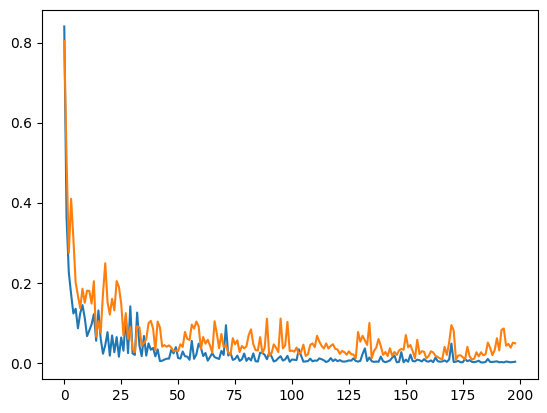

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.show()

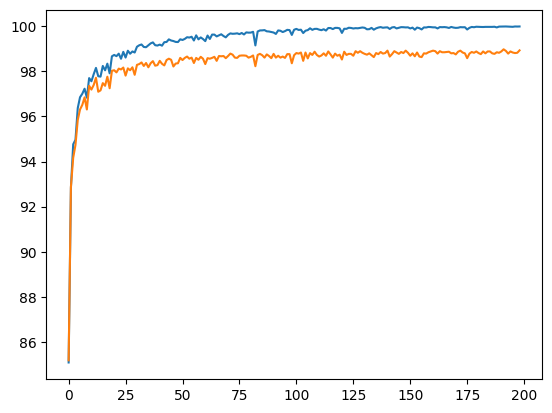

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.show()

In [ ]:
image = x_test[0].cpu()
image = image.view(-1, 1, 28, 28)
image.shape

torch.Size([1, 1, 28, 28])

In [ ]:
test_pred = []

model.eval()
for images in x_test:
    outputs = model(images.view(-1, 1, 28, 28))
    predicted = torch.max(outputs.data, 1)[1]
    test_pred.append(predicted.item())

In [ ]:
submission = pd.DataFrame({'ImageId': range(1, len(test_pred)+1), 'Label': test_pred})
submission.to_csv('./submissions/submission_regbatnor.csv', index=False)